In 1998 Nintendo released the Gameboy Camera. With this camera it was possible to take images in a resolution of 256x224 pixels (or 0.05734 megapixels). The screen resized your image to 190x144 pixels, and shows it in 4 shades of gray/green. Despite these limitations images you took are recognisable for us humans. In this post I show my adventures in improving the camera images using Deep Neural Networks!


[expand title="view helper functions"]something here[/expand]

Recently several applications of convolutional neural networks have been discovered. Examples are super-resolution (upscaling an image without loss), coloring (from grayscale to RGB), and <a href="https://arxiv.org/pdf/1504.06993.pdf" target="_blank">removing (JPEG) compression artifacts</a>. Another example is turning <a href="
https://arxiv.org/pdf/1606.03073v1.pdf" target="_blank">sketches into photorealistic face images</a>, discovered by Yağmur Güçlütürk, Umut Güçlü, Rob van Lier, and Marcel van Gerven. This last example inspired me to take gameboy camera images of faces and turn them into photorealistic images.

XXX IMAGE HERE OF THE GAMEBOY CAMERA XXX

Back in 1998, the gameboy camera got the world record as "smallest digital camera" in the Guinness book of records. An accessory you could buy was the small printer you could use to print your images. When I was 10 years old we has one of these cameras at home, and used it a lot. Although we did not have the printer, taking pictures, editing them, and playing minigames was a lot of fun. Unfortunately I could not find my old camera (no colored young Roland pictures unfortunately), but I did buy a new one so I could test my application.

In the end the result turned out very good. The generated images are really great. Although we trained on a small part of the face even pictures of whole heads seem to turn out nice.

XXX IMAGE HERE OF THE RESULTS XXX

In this blogpost I will guide you through my progress of this project. Some boring parts are hidden, but can be expanded for the full story. With the code you should be able to replicate the results. <a href="https://github.com/rmeertens/convolutional_color_gameboy_camera" target="_blank">A Git repository can be found here.</a> 

### Training data

Unfortunately, there is no training-data set with gameboy-camera images of faces together with the real picture of the person. To create a dataset I made a function that takes an image as input and creates an image with 4 shades of black. The shade is based on the mean and standard deviation of the image, to make sure that we always use 4 colors. If you look at original gameboy camera images you can see that they create gradients by alternating pixels to give the illusion of more colors. To immitate this I simply added noise on top of my original images. Note that if you want to experiment you can change the apply_effect_on_folder function to create images from sketches instead of gameboy camera images. 




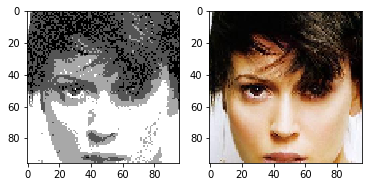

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipyd
import os
import random
import pickle
import cv2 
from sklearn.decomposition import PCA
from libs import vgg16 # Download here! https://github.com/pkmital/CADL/tree/master/session-4/libs

IMAGE_PATH = "../datasets/celebgbcamera/img_align_celeba_png" # DOWNLOAD HERE! http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
PICTURE_DATASET = os.listdir(IMAGE_PATH)

PREPROCESSED_IMAGE_PATH = "../datasets/celebgbcamera/img_align_celeba_effect"
PROCESSED_PICTURE_DATASET = os.listdir(PREPROCESSED_IMAGE_PATH)

IMAGE_WIDTH = 96
IMAGE_HEIGHT = 96
COLOR_CHANNEL_COUNT = 3
NORMALISE_INPUT = False

def load_random_picture_from_list(image_names,path):
    index_image = random.randint(0,len(image_names)-1)
    name_picture = image_names[index_image]
    path_file = os.path.join(path,name_picture)
    image = plt.imread(path_file)
    return image
    

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])


def add_sketch_effect(image):
    img_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    img_gray_inv = 255 - img_gray
    img_blur = cv2.GaussianBlur(img_gray_inv, ksize=(5, 5),sigmaX=0, sigmaY=0)

    img_blend = dodgeV2(img_gray, img_blur)
    ret,img_blend = cv2.threshold(img_blend,240,255,cv2.THRESH_TRUNC)
    return img_blend

def add_gameboy_camera_effect(image):
    img_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    mean = np.mean(img_gray)
    stdev = np.std(img_gray)
    random_noise = np.random.random_sample(size=img_gray.shape)/10
    img_gray += random_noise
    lowest = img_gray < (mean-stdev)
    second = (img_gray < (mean)) 
    third = (img_gray < (mean+stdev))
    highest = (img_gray >= 0.0)-third
    pallet = np.zeros(img_gray.shape,dtype=np.float32)
    pallet[highest]=1.0
    pallet[third]=0.66
    pallet[second]=0.33
    pallet[lowest]=0.0
    return pallet


def dodgeV2(image, mask):
    return cv2.divide(image, 255-mask, scale=256)


def burnV2(image, mask):
    return 255 - cv2.divide(255-image, 255-mask, scale=256)


def resize_image_by_cropping(image,width,height):
    """Resizes image by cropping the relevant part out of the image"""
    original_height = len(image)
    original_width = len(image[0])
    start_h = (original_height - height)//2
    start_w = (original_width - width)//2
    return image[start_h:start_h+height,start_w:start_w+width]


def apply_effect_on_folder(name_input_folder,name_output_folder):
    picture_names = os.listdir(name_input_folder)
    i = 0
    for name_picture in picture_names:
        i+=1
        if i % 250==1:
            print(i)
            print(len(picture_names))
        path_file = os.path.join(IMAGE_PATH,name_picture)
        image = plt.imread(path_file)
        image = resize_image_by_cropping(image)
        effect = add_gameboy_camera_effect(image)
        write_path_original = os.path.join(name_output_folder,name_picture+".orig")
        write_path_effect = os.path.join(name_output_folder,name_picture+".effect")
        
        np.save(write_path_original,image)
        np.save(write_path_effect,effect)
        
def load_names_images():
    names_images = [a[:6] for a in PROCESSED_PICTURE_DATASET]
    names_images = list(set(names_images))
    orig = [a+".png.orig.npy" for a in names_images]
    effect = [a+".png.effect.npy" for a in names_images]
    return list(zip(orig,effect))

def normalise_image(image,mean,stdev):
    normalised = (image-mean)/stdev
    return normalised

def normalise_numpy_images(images,mean,stdev):
    return np.array([normalise_image(image,mean,stdev) for image in images])

def denormalise_image(image,mean,stdev):
    return image*mean+stdev


class PreprocessedImageLoader:
    def get_random_images_from_set(self,count,names_images):
        Xs = []
        Ys = []
        for _ in range(count):           
            index = random.randint(0,len(names_images)-1)
            name_orig = os.path.join(self.path,names_images[index][0])
            name_effect = os.path.join(self.path,names_images[index][1])
            Xs.append( np.load(name_effect))
            Ys.append( np.load(name_orig))
        return np.array(Xs),np.array(Ys)
    
    def get_train_images(self,count):
        return self.get_random_images_from_set(count,self.trainimage_names)
    
    def get_test_images(self,count):
        return self.get_random_images_from_set(count,self.testimage_names)
    
    def __init__(self,path,image_names,trainsplit_ratio=0.8):
        assert trainsplit_ratio > 0.0
        assert trainsplit_ratio < 1.0
        self.path = path
        self.trainimage_names = names_images[:int(trainsplit_ratio*len(image_names))]
        self.testimage_names = names_images[int(trainsplit_ratio*len(image_names)):]

#apply_effect_on_folder(IMAGE_PATH,PREPROCESSED_IMAGE_PATH)
names_images = load_names_images()
imageloader = PreprocessedImageLoader(PREPROCESSED_IMAGE_PATH,names_images)

source_x, test_y = imageloader.get_test_images(10)
fig = plt.figure()
plt.subplot(121)
plt.imshow(source_x[0],cmap='gray')
plt.subplot(122)
plt.imshow(test_y[0])
plt.show()



In [2]:
import cv2


As you can see the random noise on top of the image creates the "gradients" you see in the gameboy camera images that give the illusion of more than 4 colors. Note that a downside of the crop function I programmed is that the background of the images is not really visible (even parts of the chin are hidden). 

### Data preprocessing
The preprocessing step of the project is normalising the input images. Hidden is the code that loads 30.000 training images and calculates the mean and standard deviation of the gameboy images and the original images. Just because it looks cool, this is the mean of both:

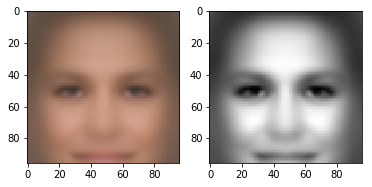

In [3]:
name_save_mean_std = "mean_std_sketches.npy"
name_save_color_mean_std = "mean_std_color.npy"
if os.path.isfile(name_save_mean_std):
    loaded_images = np.load(name_save_mean_std)
    mean_sketch = loaded_images[0]
    stdeviation_sketch = loaded_images[1]
    loaded_images = np.load(name_save_color_mean_std)
    mean_color = loaded_images[0]
    stdeviation_color = loaded_images[1]
else:
    TrainInput, TrainOutput = imageloader.get_train_images(30000) 
    sketches = np.array(TrainInput)
    color_images = np.array(TrainOutput)
    mean_sketch = np.mean(sketches,axis=0)
    stdeviation_sketch = np.std(sketches,axis=0)
    mean_color = np.mean(color_images,axis=0)
    stdeviation_color = np.mean(color_images,axis=0)
    
    to_save = np.array([mean_sketch,stdeviation_sketch])
    
    np.save(name_save_mean_std,to_save)
    to_save = np.array([mean_color,stdeviation_color])
    np.save(name_save_color_mean_std,to_save)

def normalise_image(image,mean,stdev):
    normalised = (image-mean)/stdev
    return normalised

def normalise_numpy_images(images,mean,stdev):
    return np.array([normalise_image(image,mean,stdev) for image in images])
def denormalise_image(image,mean,stdev):
    return image*mean+stdev

if NORMALISE_INPUT:
    test_x = normalise_numpy_images(source_x,mean_sketch,stdeviation_sketch)
else:
    test_x = source_x
test_x = np.expand_dims(test_x,3)
progress_images = []

fig = plt.figure()
plt.subplot(121)
plt.imshow(mean_color)
plt.subplot(122)
plt.imshow(mean_sketch,cmap='gray')
plt.show()



### Helper functions
To ease the programming I created several helper functions for operations in my graph. These are the functions I used. 
Note that there are two types of deconvolution layers: the conv2d_transpose and the resize type. 
In the beginning I only programmed the first one, but this gave me problems with strange patterns on top of my images. 

XXX INSERT IMAGES XXX

Thanks to this post http://distill.pub/2016/deconv-checkerboard/ I found out about the alternative deconvolution layer and implemented that one.

In [4]:


def conv_layer(input_image,ksize,in_channels,out_channels,stride,scope_name,activation_function=tf.nn.relu):
    with tf.variable_scope(scope_name):
        filter = tf.Variable(tf.random_normal([ksize,ksize,in_channels,out_channels],stddev=0.03))
        output = tf.nn.conv2d(input_image,filter, strides=[1, stride, stride, 1], padding='SAME')
        if activation_function:
            output = activation_function(output)
        return output, filter
    
def residual_layer(input_image,ksize,in_channels,out_channels,stride,scope_name):
    with tf.variable_scope(scope_name):
        output,out_weights = conv_layer(input_image,ksize,in_channels,out_channels,stride,scope_name+"conv1")
        output,out_weights = conv_layer(output,ksize,out_channels,out_channels,stride,scope_name+"conv2")
        cool_stuff = tf.add(output,tf.identity(input_image))
        return cool_stuff,out_weights
    
def transpose_deconvolution_layer(input_tensor,used_weights,new_shape,stride,scope_name):
    with tf.variable_scope(scope_name):
        output = tf.nn.conv2d_transpose(input_tensor, used_weights, output_shape=new_shape,strides=[1,stride,stride,1], padding='SAME')
        output = tf.nn.relu(output)
        return output
    
def resize_deconvolution_layer(input_tensor,used_weights,new_shape,stride,scope_name):
    with tf.variable_scope(scope_name):
        output = tf.image.resize_images(input_tensor,(new_shape[1],new_shape[2]))#tf.nn.conv2d_transpose(input_tensor, used_weights, output_shape=new_shape,strides=[1,stride,stride,1], padding='SAME')
        output, unused_weights = conv_layer(output,3,new_shape[3]*2,new_shape[3],1,scope_name+"_awesome_deconv")
        return output

def deconvolution_layer(input_tensor,used_weights,new_shape,stride,scope_name):
    return resize_deconvolution_layer(input_tensor,used_weights,new_shape,stride,scope_name)

    
def output_between_zero_and_one(output):
    output +=1 
    return output/2


### Loss functions

In the sketch-to-photorealistic-image paper the authors use three different loss functions: pixel-loss, style-loss, and a smoothing-loss. I use the same functions for my project. 

In [11]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/687px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg

--2017-04-24 14:13:36--  https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/687px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 199180 (195K) [image/jpeg]
Saving to: '687px-Mona_Lisa,_by_Leonardo_da_Vinci,_from_C2RMF_retouched.jpg'

687px-Mona_Lisa,_by 100%[===================>] 194.51K  --.-KB/s    in 0.03s   

2017-04-24 14:13:36 (5.81 MB/s) - '687px-Mona_Lisa,_by_Leonardo_da_Vinci,_from_C2RMF_retouched.jpg' saved [199180/199180]



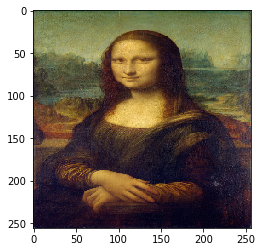

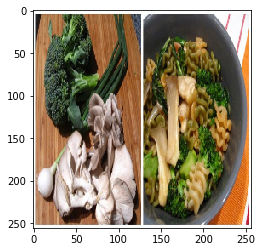

(256, 256, 3)


In [35]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
style_image = plt.imread("687px-Mona_Lisa,_by_Leonardo_da_Vinci,_from_C2RMF_retouched.jpg")
monalisa = cv2.resize(style_image,(IMAGE_HEIGHT, IMAGE_WIDTH))
plt.imshow(monalisa)
plt.show()
content_image = plt.imread("../datasets/coco/test2014/COCO_test2014_000000291436.jpg")
awesomeguy = cv2.resize(content_image,(IMAGE_HEIGHT, IMAGE_WIDTH))
plt.imshow(awesomeguy)
plt.show()
print(awesomeguy.shape)

In [5]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [6]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())


### Get the style perceptions of the style image

Doing it manually as doing this in the graph will cost a lot of computation time

In [37]:
net = vgg16.get_vgg_model()
tf.reset_default_graph()
_ , in_y = imageloader.get_train_images(3)

input_placeholder = tf.placeholder(tf.float32, [None, IMAGE_HEIGHT,IMAGE_WIDTH,3])
style_layer_names = ['conv2_1/conv2_1:0']

with tf.variable_scope("awesometest") as scope:
    feature_transformed_images = tf.import_graph_def(net['graph_def'],name='vgg',
                                                    input_map={'images:0': input_placeholder}, 
                                                    return_elements=style_layer_names)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
a = sess.run(feature_transformed_images,feed_dict={input_placeholder:np.array([monalisa])})
layer_styles = [precomputed[0] for precomputed in a]
print("We have %d layer styles" % len(layer_styles))
print(layer_styles[0].shape)
#show_graph(tf.get_default_graph())

We have 1 layer styles
(128, 128, 128)


In [45]:
tf.gradients?

In [44]:
to_optimise_image = tf.placeholder(dtype=tf.float32,shape=[None,256,256,3])#tf.Variable(np.array([awesomeguy]),dtype=tf.float32)
style_awesome_input = tf.Variable(np.array([monalisa]),dtype=tf.float32,trainable=False)
print(to_optimise_image)
net = vgg16.get_vgg_model()

with tf.variable_scope("awesometest") as scope:
    print("Going to teset")
    
    feature_transformed_image = tf.import_graph_def(net['graph_def'],name='vgg',
                                                    input_map={'images:0': to_optimise_image}, 
                                                    return_elements=['conv2_2/conv2_2:0'])


Tensor("Placeholder:0", shape=(?, 256, 256, 3), dtype=float32)
Going to teset


In [39]:
tf.reset_default_graph()

def get_patches(image,layername):
    net = vgg16.get_vgg_model()
    
    with tf.variable_scope("awesometest") as scope:

        feature_transformed_image = tf.import_graph_def(net['graph_def'],name='vgg',
                                                        input_map={'images:0': image}, 
                                                        return_elements=[layername])
    feature_transformed_image = feature_transformed_image[0]
    print(feature_transformed_image)
    
    patches = tf.extract_image_patches(feature_transformed_image, [1,3,3,1], [1,1,1,1], [1,1,1,1],'VALID')
    return patches
def get_vgg_something(image,layername):
    net = vgg16.get_vgg_model()
    
    with tf.variable_scope("awesometest") as scope:
        print("Going to teset")
        print(image)
        feature_transformed_image = tf.import_graph_def(net['graph_def'],name='vgg',
                                                        input_map={'images:0': image}, 
                                                        return_elements=[layername])
    feature_transformed_image = feature_transformed_image[0]
    return feature_transformed_image

losses = []
#to_optimise_image = tf.placeholder(tf.float32,shape=[None,IMAGE_HEIGHT, IMAGE_WIDTH, 3])
to_optimise_image = tf.Variable(np.array([awesomeguy]),dtype=tf.float32)
style_awesome_input = tf.Variable(np.array([monalisa]),dtype=tf.float32,trainable=False)
print(to_optimise_image)
for index in range(len(style_layer_names)):
    print(style_layer_names[index])
    activation_generated_image = get_vgg_something(to_optimise_image,style_layer_names[index])
    print("Activation generated image: " + str(activation_generated_image))
    stylepatches = get_patches(style_awesome_input,style_layer_names[index])
    #stylepatches = get_patches(to_optimise_image,style_layer_names[index])
    print(stylepatches)
    print("^^ stylepatches")
    print("Layer style shape: " + str(layer_styles[index].shape))
#stylepatches = get_patches(style_placeholder)
    actual_patches = stylepatches[0,:,:,:] # Only optimise one image
    #actualpatches = get_vgg_something()
    print(actual_patches)
    print(layer_styles[index].shape)
    print("resulting style: ^^^")
    print(tf.shape(actual_patches))
    noww = actual_patches.shape[0]
    nowh = actual_patches.shape[1]
    nowfilters = actual_patches.shape[2]
    print(noww)
    print(nowh)
    print(nowfilters)
    print("^^ actual patches") 
    print(actual_patches)
    newshape = [int(noww*nowh), int(nowfilters)]
    print(newshape)
    N_filters_with_N_values = tf.reshape(actual_patches,newshape,name="awesome_stuff")
    print(N_filters_with_N_values)
    N_values_with_N_filters = tf.transpose(N_filters_with_N_values)
    print(N_values_with_N_filters)
    print("Now kernel for convolution")
    kernel_for_convolution = tf.reshape(N_values_with_N_filters,[3,3,layer_styles[index].shape[2],-1])
    print(kernel_for_convolution)
    result_compare = tf.nn.conv2d(activation_generated_image, kernel_for_convolution, strides=[1, 1, 1, 1], padding='SAME')
    print(result_compare)
    lowest_losses = tf.reduce_min(result_compare, axis=3)
    print(lowest_losses)
    markov_random_field_loss = tf.reduce_sum(tf.square(lowest_losses))
    print(markov_random_field_loss)
    losses.append(markov_random_field_loss)


Tensor("Variable/read:0", shape=(1, 256, 256, 3), dtype=float32)
conv3_1/conv3_1:0
Going to teset
Tensor("Variable/read:0", shape=(1, 256, 256, 3), dtype=float32)


ValueError: Dimension size must be evenly divisible by 25088 but is 32768 for 'awesometest/vgg/Reshape' (op: 'Reshape') with input shapes: [1,8,8,512], [2].

In [19]:
print(losses[0])
optimiser = tf.train.AdamOptimizer().minimize(markov_random_field_loss)

Tensor("Sum:0", shape=(), dtype=float32)


ValueError: No variables to optimize.

In [ ]:
tf.reshape?

In [ ]:
input_placeholder = tf.placeholder(tf.float32, [None, IMAGE_HEIGHT,IMAGE_WIDTH,3])
_ , in_y = imageloader.get_train_images(3)

print(in_y.shape)
patch_size = 20
patches = tf.extract_image_patches(input_placeholder, [1,patch_size,patch_size,1], [1,1,1,1], [1,1,1,1],'VALID')
print(patches)
a = patches.eval(session=sess,feed_dict={input_placeholder:in_y})

In [ ]:
print(a.shape)
import random
for _ in range(100):
    onepatch = a[random.randint(0,2),random.randint(0,IMAGE_HEIGHT-patch_size),random.randint(0,IMAGE_HEIGHT-patch_size)]
    #print(onepatch.shape)
    cool = np.reshape(onepatch, (patch_size,patch_size,3) )
    plt.imshow(cool)
    plt.show()

In [ ]:
one = np.array([[1,2],[3,4]])
print(one.shape)
a = np.array([np.zeros((2,2)),one])
b = np.array([[5,6],[7,8]])
print(b)
print(a.shape)
c = a*b
print(c.shape)
print(c)

In [ ]:
from libs import vgg16 # Download here! https://github.com/pkmital/CADL/tree/master/session-4/libs

tf.reset_default_graph()

def get_patches(image):
    net = vgg16.get_vgg_model()
    style_layer = 'conv2_2/conv2_2:0'
    with tf.variable_scope("awesometest") as scope:

        feature_transformed_image = tf.import_graph_def(net['graph_def'],name='vgg',input_map={'images:0': input_placeholder}, return_elements=[style_layer])
    feature_transformed_image = feature_transformed_image[0]
    print(feature_transformed_image)
    
    patches = tf.extract_image_patches(feature_transformed_image, [1,3,3,1], [1,1,1,1], [1,1,1,1],'VALID')
    return patches


def get_output_layer(image):
    net = vgg16.get_vgg_model()
    style_layer = 'conv2_2/conv2_2:0'
    with tf.variable_scope("awesometest") as scope:

        feature_transformed_image = tf.import_graph_def(net['graph_def'],name='vgg',input_map={'images:0': image}, return_elements=[style_layer])
    feature_transformed_image = feature_transformed_image[0]
    return feature_transformed_image
input_placeholder = tf.placeholder(tf.float32, [None, 96,96,3])
style_placeholder = tf.placeholder(tf.float32, [96,96,3])

generated = get_output_layer(input_placeholder)
stylepatches = get_patches(style_placeholder)

print("Style patches:")
print(stylepatches)
print("Should be applied on: ")
print(generated)

In [ ]:
actual_patches = stylepatches[0,:,:,:]
print(actual_patches)
N_filters_with_N_values = tf.reshape(actual_patches,[46*46,1152])
print(N_filters_with_N_values)
N_values_with_N_filters = tf.transpose(N_filters_with_N_values)
print(N_values_with_N_filters)
kernel_for_convolution = tf.reshape(N_values_with_N_filters,[3,3,128,2116])
print(kernel_for_convolution)
result_compare = tf.nn.conv2d(generated, kernel_for_convolution, strides=[1, 1, 1, 1], padding='SAME')
print(result_compare)
lowest_losses = tf.reduce_min(result_compare, axis=3)
print(lowest_losses)
markov_random_field_loss = tf.reduce_sum(tf.square(lowest_losses))
print(markov_random_field_loss)

    

In [38]:

net = vgg16.get_vgg_model()
tf.reset_default_graph()

style_layer_names = ['conv3_1/conv3_1:0','conv4_1/conv4_1:0']
content_layer_names = ['conv4_2/conv4_2:0']

def get_output_layers_vgg(image, layer_names):
    '''
     example: get_output_layers_vgg(in_tensor,['conv2_2/conv2_2:0'])
    '''
    net = vgg16.get_vgg_model()
    with tf.variable_scope("awesometest") as scope:
        print(image)
        print(layer_names)
        feature_transformed_images = tf.import_graph_def(net['graph_def'],name='vgg',
                                                        input_map={'images:0': image}, 
                                                        return_elements=layer_names)
    return feature_transformed_images
def precompute_markov_random_field_perception(style_image_input,style_layer_names,sess):
    tf.reset_default_graph()
    to_check = np.array([style_image_input])
    print(to_check.shape)
    input_image = tf.placeholder(tf.float32,[None,96,96,3])
    print(input_image)
    output_layers = get_output_layers_vgg(input_image,style_layer_names)
    print(output_layers)

    sess.run(tf.global_variables_initializer())
    perceptions = sess.run(output_layers,feed_dict={input_image:to_check})
    return perceptions



    
def markov_random_field_loss(generated_image, preprocessed_perception, perception_layers):
    assert len(perception_layers) == len(preprocessed_perception)
sess = tf.InteractiveSession()
perc = precompute_markov_random_field_perception(in_y[0],['conv2_2/conv2_2:0'],sess)

(1, 96, 96, 3)
Tensor("Placeholder:0", shape=(?, 96, 96, 3), dtype=float32)
Tensor("Placeholder:0", shape=(?, 96, 96, 3), dtype=float32)
['conv2_2/conv2_2:0']
[<tf.Tensor 'awesometest/vgg/conv2_2/conv2_2:0' shape=(?, 48, 48, 128) dtype=float32>]


RuntimeError: The Session graph is empty.  Add operations to the graph before calling run().

In [ ]:
print(a[0].shape)

In [ ]:
filterW = tf.Variable(initial)
result_compare = tf.nn.conv2d(x, filterW, strides=[1, 1, 1, 1], padding='SAME')


In [ ]:
print(patches)
patcheslist = tf.reshape(patches,(-1,46*46,1152))
print(patcheslist)
stylepatches = tf.placeholder(tf.float32,[2116,1152])


In [ ]:
print(patcheslist)
print(stylepatches)

In [ ]:
cosine_similarity = tf.matmul(patcheslist, tf.transpose(stylepatches, [1, 0]))
closest_words = tf.argmax(cosine_similarity, 1)  # shape [batch_size], type int64
print(closest_words)

### [n.name for n in tf.get_default_graph().as_graph_def().node]


In [ ]:

def get_style_layer_vgg16(image):
    net = vgg16.get_vgg_model()
    style_layer = 'conv2_2/conv2_2:0'
    feature_transformed_image = tf.import_graph_def(
        net['graph_def'],
        name='vgg',
        input_map={'images:0': image},return_elements=[style_layer])
    feature_transformed_image = (feature_transformed_image[0])
    return feature_transformed_image

def get_style_loss(target,prediction):
    feature_transformed_target = get_style_layer_vgg16(target)    
    feature_transformed_prediction = get_style_layer_vgg16(prediction)
    feature_count = tf.shape(feature_transformed_target)[3]
    style_loss = tf.reduce_sum(tf.square(feature_transformed_target-feature_transformed_prediction))
    style_loss = style_loss/tf.cast(feature_count, tf.float32)
    return style_loss

def get_smooth_loss(image):
    batch_count = tf.shape(image)[0]
    image_height = tf.shape(image)[1]
    image_width = tf.shape(image)[2]    

    horizontal_normal = tf.slice(image, [0, 0, 0,0], [batch_count, image_height, image_width-1,3])
    horizontal_one_right = tf.slice(image, [0, 0, 1,0], [batch_count, image_height, image_width-1,3])
    vertical_normal = tf.slice(image, [0, 0, 0,0], [batch_count, image_height-1, image_width,3])
    vertical_one_right = tf.slice(image, [0, 1, 0,0], [batch_count, image_height-1, image_width,3])
    smooth_loss = tf.nn.l2_loss(horizontal_normal-horizontal_one_right)+tf.nn.l2_loss(vertical_normal-vertical_one_right)
    return smooth_loss

def get_pixel_loss(target,prediction):
    pixel_difference = target - prediction
    pixel_loss = tf.nn.l2_loss(pixel_difference)
    return pixel_loss

### The network
The network consists of many convolutional layers for scaling the image down, adding/removing information, and scaling it back to the size we want it to be. The network is inspired by the paper "Convolutional Sketch Inversion", but there are some minor difference. One thing I ignored is the batch normalisation layer. Although it is easy to add my network, this network already trained fast enough. Another thing I did was use only two residual layers, this is mostly because of my lack of computing power. 

In [ ]:
input_placeholder = tf.placeholder(tf.float32, [None, IMAGE_HEIGHT,IMAGE_WIDTH,1])
output_placeholder = tf.placeholder(tf.float32,[None,IMAGE_HEIGHT,IMAGE_WIDTH,COLOR_CHANNEL_COUNT])
computed_batch_size = tf.shape(input_placeholder)[0]

conv1, conv1_weights = conv_layer(input_placeholder,9,1,32,1,"conv1")
conv2, conv2_weights = conv_layer(conv1,3,32,64,2,"conv2")
conv3, conv3_weights = conv_layer(conv2,3,64,128,2,"conv3")
res1, res1_weights = residual_layer(conv3,3,128,128,1,"res1")
res2, res2_weights = residual_layer(res1,3,128,128,1,"res2")
deconv1 = deconvolution_layer(res2,conv2_weights,[computed_batch_size,48,48,64],2,'deconv1')
deconv2 = deconvolution_layer(deconv1,conv3_weights,[computed_batch_size,96,96,32],2,'deconv2')

conv4, conv4_weights = conv_layer(deconv2,9,32,3,1,"last_layer",activation_function=tf.nn.tanh)
output = output_between_zero_and_one(conv4)


pixel_loss = get_pixel_loss(output_placeholder,output)
style_loss = get_style_loss(output_placeholder,output)
smooth_loss = get_smooth_loss(output)

style_factor = 1.0
pixel_factor = 1.0
smooth_factor = 0.0001

loss = pixel_factor*pixel_loss + style_factor*style_loss+smooth_factor*smooth_loss

optimizer = tf.train.AdamOptimizer().minimize(loss)


In [ ]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

def show_progress(input_image,target,generated):
    fig = plt.figure()

    plt.subplot(131)
    plt.imshow(input_image,cmap='gray')
    plt.subplot(132)
    plt.imshow(target)
    plt.subplot(133)
    plt.imshow(generated)
    plt.show()

### Results
After explainig the image generation methods and network, it is time for running the network! It is really interesting to see the output of the network over time. I display several of them, and all of them in a sped-up version in the GIF that is generated at the end of the training epochs. 

In [ ]:
n_epochs = 10000
batch_size = 32

for epoch_i in range(n_epochs):
    in_x, in_y = imageloader.get_train_images(batch_size)
    if NORMALISE_INPUT:
        in_x = normalise_numpy_images(in_x,mean_sketch,stdeviation_sketch)
    in_x = np.expand_dims(in_x,3)
    
    _,l = sess.run([optimizer,loss], feed_dict={input_placeholder:in_x ,output_placeholder: in_y })
    
    if epoch_i % 100==1:
        colored_images = sess.run(output, feed_dict={input_placeholder:test_x,output_placeholder:test_y})
        generated = np.clip(colored_images,0.0,1.0)
        generated = generated[0]
        progress_images.append(generated)
        if epoch_i < 800 or epoch_i > 19900:
            show_progress(source_x[0],test_y[0],generated)
        
print("building progress gif out of " + str(len(progress_images)) + " images")
gif.build_gif(progress_images, interval=0.1, dpi=72, save_gif=True, saveto='animation.gif',show_gif=False)
ipyd.Image(url='animation.gif', height=200, width=200)

### Testdata 
To test my algorithm I tried to convert the following data using the trained network:
- testdata from the celebrity dataset
- images from people I found using Google Images by typing in "gameboy camera"
- faces that are in the gameboy camera (also found online)
- pictures of my face

### Testdata from the celebrity dataset

In [ ]:
for index,generated_image in enumerate(colored_images):
    show_progress(source_x[index],test_y[index],generated_image)

This all looks pretty good to me. This was expected, as these images were taken with the same restrictions as the trainset. 

### Images from the internet

In [ ]:

def show_colored_pictures(test_pictures):
    for name_picture in test_pictures:
        path_file = os.path.join(name_picture)
        image = plt.imread(path_file)
        image = cv2.resize(image,(96,96))
        image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        in_x = np.array([image])
        if NORMALISE_INPUT:
            in_x = normalise_numpy_images(in_x,mean_sketch,stdeviation_sketch)
        in_x = np.expand_dims(in_x,3)

        colored_images = sess.run(output, feed_dict={input_placeholder:in_x})
        
        fig = plt.figure()
        plt.subplot(121)
        plt.imshow(image,cmap='gray')
        plt.subplot(122)
        plt.imshow(colored_images[0])
        plt.show()

        
test_pictures = ['test19.png','test18.png','test1.png','test2.png','test3.png']
show_colored_pictures(test_pictures)

I was impressed with how well these images turned out given that they do not follow the pattern as the train images. Even though the eyes are on a different spot, and a larger area was cropped around the face, I think the network created pretty good images.  

### Images from the gameboy itself
When trying to display an empty animation the gameboy camera has several faces it can display warning you that you have to create an animation first. I took two of these faces and tried colorizing them. 

In [ ]:
test_pictures = ['test4.png','test5.png']

show_colored_pictures(test_pictures)

Looks pretty good to me!

### Images I took
A big problem trying to create color images from my own face was getting them off the gameboy camera. Buying the camera was easy, but finding a gameboy printer was impossible. Although somebody made a cable to put the images through the link cable on your pc, this also was impossible to find. What was left was the great method of taking images of the screen. A problem with this approach is that the lighting is always a lot off. As our network is trained on images that have equal lightning this posed a bit of a problem. This was a problem that was not easy to solve, and we have to do with colored images from noisy input. 



In [ ]:
test_pictures = ['test25.png','test26.png','test27.png','test28.png','test29.png','test31.png']
show_colored_pictures(test_pictures)

### Output last deconvolution
To see what the network "learned" the activations in the last layer can be visualised. Manually cherry-picking some interesting layers gives this result:

In [ ]:
last_layer = sess.run(deconv2, feed_dict={input_placeholder:test_x})
inspect_layer = last_layer[0]

last_layer_activations = []
for inspect_convolution_output in range(inspect_layer.shape[2]):
    last_layer_activations.append(inspect_layer[:,:,inspect_convolution_output])

last_activation_montage = utils.montage(last_layer_activations)
plt.imshow(last_activation_montage,cmap='gray')
plt.show()


### PCA of each layer
As you can see the network seems to encode features such as hair, eyes, side of the face. 
The last interesting thing I wanted to show is a visualising the principal components in each layer

In [ ]:


all_steps = sess.run([input_placeholder,conv1,conv2,conv3,res1,res2,deconv1,deconv2,output], feed_dict={input_placeholder:test_x,output_placeholder:test_y})
for index_layer,layer in enumerate(all_steps[1:-1]):
    print("Principal components output layer " + str(index_layer+1))
    first_image = layer[0]
    original_shape = first_image.shape
    original_dimensions = original_shape[2]
    first_image = np.reshape(first_image, (-1,original_dimensions))
    pca = PCA(n_components=3)
    fitted = pca.fit_transform(first_image)
    fitted = np.reshape(fitted,(original_shape[0],original_shape[1],-1))

    fig = plt.figure()
    plt.subplot(131)
    plt.imshow(fitted[:,:,0],cmap='gray')
    plt.subplot(132)
    plt.imshow(fitted[:,:,1],cmap='gray')
    plt.subplot(133)
    plt.imshow(fitted[:,:,2],cmap='gray')
    plt.show()

The output of the principal components is both interesting and a bit obvious. The network learns to encode the skin, hair and background of the input images (just like we seen before). 

### Interesting observations/lessons learned
During this project I learned a lot of lessons. The lesson about different deconvolution layers is something I already described above. Another interesting lesson is that I started with normalising the output of the neural network.This yielded nice results early in training (outputting only zeros is already a good guess), but later this network had a lot of problems. The output of a barely trained network can be seen below. Unfortunately faces that were far away from the norm (i.e. people with hair in front of their face, sunglasses, people looking sideways) became blurry. 

One question I asked myself was: how does this task compare to coloring sketch images? The details of the face are very blurry, but the outline of face details is still preserved. Because the areas between features are filled with 4 colours, the network has more grasp on what the resulting colour should compared to the line sketch problem. One interesting thing is that this network gives the right skincolor to people most of the time.   

## Conclusion
Create photorealistic color images from gameboy camera images is a possibility! Going from 0.05 megapixels 4-color-grayscale images to full-color faces is something convolutional neural networks can learn. 

If you have other ideas for styles to convert from, or other things you would like to try, let me know. I am always willing to answer your questions. If you enjoyed reading this, please leave a comment or share this post to others who might be interested. 


In [ ]:
in_x, in_y = get_random_line_sketches(3)
colored_images = sess.run(output, feed_dict={input_placeholder:in_x})
#print(colored_images[0])
print(in_y[0])

plt.imshow(in_y[0])
plt.show()

plt.imshow(colored_images[0])

In [ ]:

a = get_random_gameboy_camera(2)

plt.imshow(a[0][0],cmap='gray')
#         gray_image = rgb2gray(image)
#         Xs.append(gray_image)
#         Ys.append(image)
#     return np.array(Xs), np.array(Ys)


In [ ]:
first_image = plaything[0]
print(first_image.shape)
for i in range(first_image.shape[2]):
    plt.imshow(first_image[:,:,i],cmap='gray')
    plt.show()

In [ ]:

first_image = plaything[0]
print(first_image.shape)
first_image = np.reshape(first_image, (-1,32))
print(first_image.shape)
pca = PCA(n_components=3)
fitted = pca.fit_transform(first_image)
print(fitted.shape)
fitted = np.reshape(fitted,(96,96,-1))
print('whoo')
print(fitted.shape)
plt.imshow(fitted)
plt.show()
plt.imshow(fitted[:,:,0],cmap='gray')
plt.show()
plt.imshow(fitted[:,:,1],cmap='gray')
plt.show()
plt.imshow(fitted[:,:,2],cmap='gray')
plt.show()

In [ ]:
print(conv_weights_first_layer.shape)
for i in range(conv_weights_first_layer.shape[3]):
    layer_here = conv_weights_first_layer[:,:,:,i]
    layer_here = layer_here[:,:,0]
    print(layer_here.shape)
    
    #layer_here = np.reshape(layer_here,(9,9,32,1))
    plt.imshow(layer_here,cmap='gray',interpolation='nearest')
    plt.show()

In [ ]:
g = tf.Graph()
with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    tf.import_graph_def(net['graph_def'], name='vgg')
    names = [op.name for op in g.get_operations()]
print(names)

In [ ]:
[name_i for name_i in names if 'conv' in name_i]

In [ ]:
from skimage.data import coffee

# output layer marcel uses: 'vgg/conv2_2/conv2_2'
# but with a relu something on it....
# which this one does not seem te have...

og = coffee()
plt.imshow(og)
img = vgg16.preprocess(og)
img_4d = img[np.newaxis]
x = g.get_tensor_by_name(names[0] + ':0')
softmax = g.get_tensor_by_name(names[-2] + ':0')

with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    res = softmax.eval(feed_dict={x: img_4d})[0]
    print([(res[idx], net['labels'][idx])
           for idx in res.argsort()[-5:][::-1]])

In [ ]:
img_4d.shape

In [ ]:
#tested_targets = in_y
#tested_predictions = colored_images
img_4d = np.array(vgg16.preprocess(tested_predictions[0]))
print(img_4d.shape)
img_4d = np.array([img_4d])

x = g.get_tensor_by_name(names[0] + ':0')
softmax = g.get_tensor_by_name(names[-2] + ':0')

with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    res = softmax.eval(feed_dict={x: img_4d})[0]
    print([(res[idx], net['labels'][idx])
           for idx in res.argsort()[-5:][::-1]])
    
with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    content_layer = 'vgg/conv2_2/conv2_2:0'
    content_features = g.get_tensor_by_name(content_layer).eval(
            session=sess,
            feed_dict={x: img_4d,
                'vgg/dropout_1/random_uniform:0': [[1.0] * 4096],
                'vgg/dropout/random_uniform:0': [[1.0] * 4096]
            })
print(content_features.shape)
to_show = content_features[0]
for i in range(128):
    plt.imshow(to_show[:,:,i])
    plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
from scipy.misc import imread, imresize
from imagenet_classes import class_names
from vgg16 import vgg16

PREPROCESSED_IMAGE_PATH = "/home/roland/clinworkspace/imagesFollowing4"
PROCESSED_PICTURE_DATASET = os.listdir(PREPROCESSED_IMAGE_PATH)

# sess = tf.Session()
# imgs = tf.placeholder(tf.float32, [None, 224, 224, 3])
# vgg = vgg16(imgs, 'vgg16_weights.npz', sess)
for image_name in PROCESSED_PICTURE_DATASET:
    image_name = os.path.join(PREPROCESSED_IMAGE_PATH,image_name)
    img1 = imread(image_name)
    img1 = imresize(img1, (224, 224))

    w, h = img1.shape
    ret = np.empty((w, h, 3), dtype=img1.dtype)
    ret[:, :, 0] = img1
    ret[:, :, 1] = img1
    ret[:, :, 2] = img1
    img1 = ret
    plt.imshow(img1)
    plt.show()

    prob = sess.run(vgg.probs, feed_dict={vgg.imgs: [img1]})[0]
    preds = (np.argsort(prob)[::-1])[0:5]
    
    for p in preds:
        print(class_names[p], prob[p])
# net = vgg16.get_vgg_model()

# print([n.name for n in net['graph_def'].node])

# # #print()
# # #style_layer = 'vgg/conv2_1/conv2_2:0'
# feature_transformed_target = tf.import_graph_def(
#         net['graph_def'],
#         name='vgg',
#         input_map={'images:0': output_placeholder},return_elements=["conv2_2/conv2_2:1"])
# print(output_placeholder)
# print(final_output)
# feature_transformed_prediction = tf.import_graph_def(
#         net['graph_def'],
#         name='vgg',
#         input_map={'images:0': final_output},return_elements=["conv2_2/conv2_2:1"])
